In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Plant2021 - PyTorch - Submission

# Overview

* Plant Pathology 2021 Competition
* Use pretrained PyTorch ResNet model
* Multi-label classification


The trained model was designed in the Norbook *Plant2021 - PyTorch - ResNet*. 

## Imports

In [2]:
from typing import List, Dict

import random
import os

import numpy as np
import pandas as pd
import PIL

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T
from torchvision.transforms import functional as F

import skimage.io as io
import skimage.feature
from skimage import color
from skimage import segmentation

from tqdm.notebook import tqdm

## Configuration

In [3]:
import torch
print(torch.__version__)

1.7.0


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=15)
plt.rc('axes', titlesize=18)  
plt.rc('xtick', labelsize=10)  
plt.rc('ytick', labelsize=10)

In [5]:
class Config: 
    DEVICE = 'cpu'
    INPUT_PATH = '../input/plant-pathology-2021-fgvc8'
    OUTPUT_PATH = './'
    BATCH_SIZE = 32
    RANDOM_STATE = 2021
    SAMPLE_FRAC = 0.01
    IMG_SIZE = 224
    TRAIN_DATA_FILE = os.path.join(INPUT_PATH, 'train.csv')
    SAMPLE_SUBMISSION_FILE = os.path.join(INPUT_PATH, 'sample_submission.csv')
    SUBMISSION_FILE = os.path.join(OUTPUT_PATH, 'submission.csv')
    MODEL_FILE = f'../input/plant2021-pytorch-resnet/plant2021_{DEVICE}.pth'
    CLASSES = [
        'rust', 
        'complex', 
        'healthy', 
        'powdery_mildew', 
        'scab', 
        'frog_eye_leaf_spot'
    ]
    N_CLASSES = len(CLASSES)
    CLASS_THRESHOLD = 0.3
    
    folders = dict({
        'data': INPUT_PATH,
        'train':  os.path.join(INPUT_PATH, 'train_images'),
        'test': os.path.join(INPUT_PATH, 'test_images')
    })
    
    @staticmethod
    def set_seed():
        torch.manual_seed(Config.RANDOM_STATE)
        random.seed(Config.RANDOM_STATE)
        np.random.seed(Config.RANDOM_STATE)
        
Config.set_seed()        

In [6]:
print(f'Using {Config.DEVICE} device.')

Using cpu device.


In [7]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

## Load images labels

In [8]:
def read_image_labels():
    df = pd.read_csv(Config.TRAIN_DATA_FILE).set_index('image')
    return df

In [9]:
img_labels = read_image_labels().sample(
    frac=Config.SAMPLE_FRAC, 
    random_state=Config.RANDOM_STATE
)

img_labels.head()

,labels
image,
a6947239bc04b5fc.jpg,scab
fd30e99e465876c0.jpg,healthy
b3eb96cbb40254b2.jpg,rust
d5cd9d0c2ca2e3e4.jpg,scab
d5f403d4fb2c5069.jpg,healthy


In [10]:
image_ids = pd.read_csv(Config.SAMPLE_SUBMISSION_FILE).set_index('image')
image_ids

,labels
image,
85f8cb619c66b863.jpg,healthy
ad8770db05586b59.jpg,healthy
c7b03e718489f3ca.jpg,healthy


## Label distribution

In [11]:
def get_image_infos(img_labels):
    df = img_labels.reset_index().groupby(by='labels').count().reset_index()
    df.columns = ['disease', 'count']
    
    df['%'] = np.round((df['count'] / img_labels.shape[0]), 2) * 100
    df = df.set_index('disease').sort_values(by='count', ascending=False)

    return df

In [12]:
get_image_infos(img_labels)

,count,%
disease,,
scab,52,28.0
healthy,45,24.0
frog_eye_leaf_spot,36,19.0
rust,19,10.0
complex,15,8.0
powdery_mildew,7,4.0
scab frog_eye_leaf_spot,4,2.0
frog_eye_leaf_spot complex,3,2.0
rust complex,2,1.0


In [13]:
img_labels.head()

,labels
image,
a6947239bc04b5fc.jpg,scab
fd30e99e465876c0.jpg,healthy
b3eb96cbb40254b2.jpg,rust
d5cd9d0c2ca2e3e4.jpg,scab
d5f403d4fb2c5069.jpg,healthy


## One hot encoding

In [14]:
def get_single_labels(unique_labels) -> List[str]:
    single_labels = []
    
    for label in unique_labels:
        single_labels += label.split()
        
    single_labels = set(single_labels)
    return list(single_labels)

In [15]:
def get_one_hot_encoded_labels(dataset_df) -> pd.DataFrame:
    df = dataset_df.copy()
    
    unique_labels = df.labels.unique()
    column_names = get_single_labels(unique_labels)
    
    df[column_names] = 0        
    
    # one-hot-encoding
    for label in unique_labels:                
        label_indices = df[df['labels'] == label].index
        splited_labels = label.split()
        df.loc[label_indices, splited_labels] = 1
    
    return df

In [16]:
one_hot_encoded_labels = get_one_hot_encoded_labels(img_labels)
one_hot_encoded_labels.head()

,labels,scab,healthy,powdery_mildew,complex,rust,frog_eye_leaf_spot
image,,,,,,,
a6947239bc04b5fc.jpg,scab,1,0,0,0,0,0
fd30e99e465876c0.jpg,healthy,0,1,0,0,0,0
b3eb96cbb40254b2.jpg,rust,0,0,0,0,1,0
d5cd9d0c2ca2e3e4.jpg,scab,1,0,0,0,0,0
d5f403d4fb2c5069.jpg,healthy,0,1,0,0,0,0


## Visualization of images

In [17]:
def get_image(image_id, kind='train'):
    """Loads an image from file
    """
    fname = os.path.join(Config.folders[kind], image_id)
    return PIL.Image.open(fname)

## Augmentation pipeline

In [18]:
image_transfom = A.Compose([
    A.Resize(
        height=Config.IMG_SIZE,
        width=Config.IMG_SIZE,
    ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

## Database

In [19]:
from scipy.stats import bernoulli
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class PlantDataset(Dataset):
    def __init__(self, 
                 image_ids, 
                 targets,
                 transform=None, 
                 target_transform=None, 
                 kind='train'):
        self.image_ids = image_ids
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.kind = kind
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img = np.array(get_image(self.image_ids.iloc[idx], kind=self.kind))
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        target = self.targets[idx]
        if self.target_transform:
            target = self.target_transform(target)
        
        return img, target

In [20]:
X_val = pd.Series(img_labels.index)
y_val = np.array(one_hot_encoded_labels[Config.CLASSES])

In [21]:
val_set = PlantDataset(X_val, y_val, transform=image_transfom, kind='train')
val_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE, shuffle=True)

## Create model and load weights

In [22]:
model = model = torch.load('../input/ppresearch02/densenet121_0layers_hyp1.pt', map_location=torch.device('cpu'))

## Confusion matrix

In [23]:
def predict(model, loader):
    y_true = np.empty(shape=(0, 6), dtype=np.int)
    y_pred_proba = np.empty(shape=(0, 6), dtype=np.int)

    stream = tqdm(loader)
    for batch, (X, y) in enumerate(stream, start=1):
        X = X.to(Config.DEVICE)
        y = to_numpy(y.to(Config.DEVICE))
        pred = to_numpy(model(X))

        y_true = np.vstack((y_true, y))
        y_pred_proba = np.vstack((y_pred_proba, pred))
        
    return y_true, y_pred_proba

In [24]:
y_true, y_pred_proba = predict(model, val_loader)

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(
    y_test, 
    y_pred_proba, 
    threshold=Config.CLASS_THRESHOLD, 
    label_names=Config.CLASSES
)-> None:
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    c_matrices = multilabel_confusion_matrix(y_test, y_pred)
    
    cmap = plt.get_cmap('Blues')
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    for cm, label, ax in zip(c_matrices, label_names, axes.flatten()):
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap);

        ax.set_xlabel('Predicted labels');
        ax.set_ylabel('True labels'); 
        ax.set_title(f'{label}');

    plt.tight_layout()    
    plt.show()

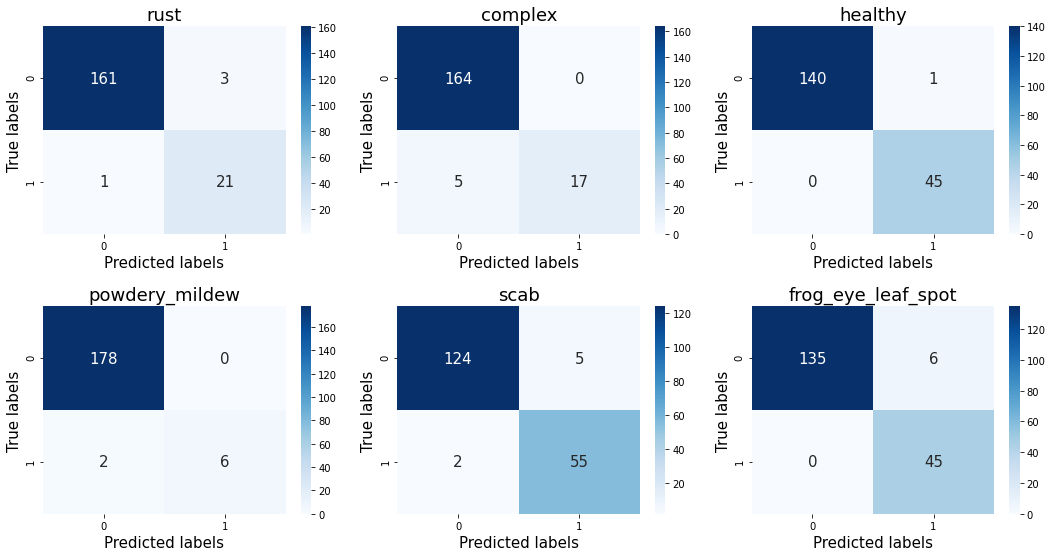

In [26]:
plot_confusion_matrix(y_true, y_pred_proba)

## Submission

In [27]:
def save_submission(model):
    image_ids = pd.read_csv(Config.SAMPLE_SUBMISSION_FILE)
    
    dataset = PlantDataset(
        image_ids['image'], 
        image_ids['labels'], 
        transform=image_transfom, 
        kind='test'
    )
    
    loader = DataLoader(dataset)

    for idx, (X, _) in enumerate(loader):
        X = X.float().to(Config.DEVICE)
        y_pred = to_numpy(torch.argmax(model(X), dim=1))

        pred_labels = ' '.join([Config.CLASSES[i] for i in y_pred]).strip()
        image_ids.iloc[idx]['labels'] = pred_labels
    
    # save data frame as csv
    image_ids.set_index('image', inplace=True)
    image_ids.to_csv(Config.SUBMISSION_FILE)
    
    return image_ids

In [28]:
save_submission(model)   

,labels
image,
85f8cb619c66b863.jpg,scab
ad8770db05586b59.jpg,frog_eye_leaf_spot
c7b03e718489f3ca.jpg,frog_eye_leaf_spot
